![Banner](./../0-Course-info/images/bannerSoB.png)

# Work with Ocean Color Products and point Time Series   

**Author: Suhyb Salama, ITC**  


## Purpose 
This exercise introduces you to [Google Earth Engine (GEE)](https://earthengine.google.com/) and its functionalities from within python script in [jupyter notebook](https://jupyter.org/). The exercise is a follow up on the [first exercise on Google Earth Engine](./1.1_work_OC_TS.ipynb).


## Prerequisites
- You should have an account in Google Earth Engine. If not done yet please [sign up now](https://earthengine.google.com/signup/).
- You should have worked out the [first exercise on Google Earth Engine](./1.1_work_OC_TS.ipynb) 

## What you will learn
1. Access Google Earth Engine (GEE) with your account;
2. Access Ocean Color products on GEE;
3. Perform a temporal averaging and visualize the results;
4. Perform spatial subsets and averaging of the data;
5. Use pandas to work on point time series.

## What will you achieve
At the end of this exercise you will be able to use Google Earth Engine to access satellite data, visualize and manipulate these data using python scripts in jupyter notebooks.



### The work comprises sequential steps that you will perform, are you ready? 

### *off you go...*

You may skip **ee.Authenticate()** step when you come here straight from the previous exercise because the authentication will be still valid.


 ## Import Google Earth API.
 This API contains all the functionalities of Google Earth Engine (GEE)

In [1]:
import ee

## Initialize the authentication process.
This process will let you log in with your user name and password
* if you have already Authenticate your entrance to GEE you can skip this step.

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AVHEtk5TR7ap_YBHsTXk5g95oYa6yWfJhis0-Juv9DJPe5p-8tQU3k4es2U



Successfully saved authorization token.


## Import Google Earth mapping capabilities

More information on the functionality of the *geemap* python package can be found at this [link](https://geemap.org/), which includes a [cheat sheet](https://geemap.org/cheatsheet/), [tutorials](https://geemap.org/tutorials/) and [book](https://book.geemap.org/) with valuable resources. 
The syntax of many of the Google Earth Engine functions that are also callable with the *geemap* site package can be found under the [Client Libraries](https://developers.google.com/earth-engine/apidocs/).

In [3]:
import pandas as pd
import numpy as np
import geemap
import geemap.colormaps as cm
Map =geemap.Map()

## Data Access
Get access to [MODIS product of Ocean Color](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#description). 

In [4]:
MODIS_OC_DS = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI")

### Interrogate 
get some information on the data set of *MODIS_OC_DS*

- Select one layer and list the band names
- The [descriptions of bands](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#bands) provides details on the content of the data set.

In [5]:
first_image = MODIS_OC_DS.first()
Bname = first_image.get('system:band_names')
print('system:band_names', Bname.getInfo())

system:band_names ['chlor_a', 'nflh', 'poc', 'Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678', 'sst']


### Data filtering
- Select Chlorophyll a concentration products *chlor_a* and filter the product to staring and ending times


In [6]:
selected_bands = 'chlor_a'
sY=2003
sM=1
sD=1
eY=2021
eM=12
eD =31
start_date = ee.Date.fromYMD(sY, sM, sD)
end_date   = ee.Date.fromYMD(eY, eM, eD)

ChlaDS = MODIS_OC_DS.select(selected_bands).filter(ee.Filter.date(start_date, end_date))

* Count how many images

In [7]:
count = ChlaDS.size()
valCount=count.getInfo()
print('Numbre of images is : ', str(valCount)+'\n')

Numbre of images is :  6849



* Compute the average Chl-a for the whole period 

In [8]:
DecadalMeanChla= ChlaDS.reduce(ee.Reducer.mean())


## Visualize the calculated mean
* Select a color palette from available library. GEE uses the same convention used in [MatPlotLib package for python](https://matplotlib.org/stable/tutorials/colors/colormaps.html).  
* Visualization requires three parameters, the min (= 0) and max (= 0.6 works for this example) values on which the color palette will be stretched, and the palette.  
* Set the center point {longitude (long), latitude (lat)} of the visualization and a zoom-in scale using *Map.setCenter(long, lat, scale)*  
* Add the Layer to the Google map and give it a name, here we use *MeanChl-a*

In [9]:
val= cm.palettes.Spectral
palette=val.default

Vis = {
  'min': 0,
  'max': 0.65,
  'palette': palette}

Map.setCenter(-30,14,5)
Map.addLayer(DecadalMeanChla, Vis, 'MeanChl-a')
Map

Map(center=[14, -30], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(To…

## Time aggregation

### Compute the monthly mean
To bin the daily data into monthly, we need two *for loops*, one for the years and one for the months. An Alternative to using *for loops* is to  apply the *.map* functionality twice, first on years and second on months.

The script below shows a nested functions of two application of *.map*. The core for binning daily to monthly data is the function **createMean**.

**createMean**: for a specific year, it iterate on the months, whereby per month the daily data are summed. The for loop on the *years* would iterate on the years. this function is encapsulated by the **getMonthlyMean** which run **createMean** on months. Later the **getMonthlyMean** is run on years.


- Create a series of years and months to loop on

In [10]:
myears=range(sY,eY+1)
mmonths=range(1,12+1)
years = ee.List.sequence(sY, eY)
months = ee.List.sequence(sM, eM)

- Define the functions **getMonthlyMean** and **createMean**

In [11]:
def getMonthlyMean(iy):
    def createMean(im):
        sDate = ee.Date.fromYMD(iy, im, sD)
        eDate = sDate.advance(1, 'month')
        monthFiltered = ChlaDS.filter(ee.Filter.date(sDate, eDate))
        msum = monthFiltered.reduce(ee.Reducer.mean())
        return msum.set({
            'system:time_start': sDate.millis(),
            'system:time_end': eDate.millis(),
            'year': iy,
            'month': im,
            'date': sDate.millis()})
    return months.map(createMean)

#### Apply monthly binning 
Run the monthly binning function and visualize the first month and investigate the results:
1. count the number of images in the image collection resulting from the function **getMonthlyMean**
2. add the the first image and visualize, use the *system:time_start* property as the name of the layer 

In [12]:
monthlyChla = ee.ImageCollection.fromImages(years.map(getMonthlyMean).flatten())

count = monthlyChla.size()
valCount=count.getInfo()
print('Numbre of monthly mean images is : ', str(valCount)+'\n')

first_image = monthlyChla.first()
Map.setCenter(-30,14,5)

iname=ee.Date(first_image.get('system:time_start')).format("yyyy-MM-dd")

Map.addLayer(first_image, Vis, iname.getInfo())
Map

Numbre of monthly mean images is :  228



Map(bottom=4074.0, center=[14, -30], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

### Compute the monthly climatology
**Monthly climatology** is the the mean of a month over all years of observations.

The function **getMonthlyClimatology** for each month (from 1 to 12) will average all years of observations.

In [13]:
def getMonthlyClimatology(mm):
    img =  monthlyChla.filter(ee.Filter.calendarRange(sY,eY , 'year')).filter(ee.Filter.calendarRange(mm, mm, 'month'))
    msum = img.reduce(ee.Reducer.mean())
    timeStamp = ee.Date.fromYMD(sY,mm,1)
    return msum.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': sY,
        'month': mm,
        'date': timeStamp.millis()})

In [14]:
MonthlyClim= ee.ImageCollection.fromImages(months.map(getMonthlyClimatology).flatten()) 

#### Check 
Check the number of bands in the image collection resulting form the function **getMonthlyClimatology** and visualize the first month.

In [15]:
count = MonthlyClim.size()
valCount=count.getInfo()
print('Number of months count: ', str(valCount)+'\n')

first_image = MonthlyClim.first()

iname=(first_image.get('month').getInfo())
Map.addLayer(first_image, Vis, 'Monthly Climatology of:  '+str(iname))
Map

Number of months count:  12



Map(bottom=4074.0, center=[14, -30], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HB…

### Compute the yearly mean
The function **getYearlyMean** will take a list of years ,i.e. [2003-2021], and per year will filter the data for all months and average them.  

In [16]:
def getYearlyMean(yy):
    img = monthlyChla.filter(ee.Filter.calendarRange(yy,yy , 'year')).filter(ee.Filter.calendarRange(sM, eM, 'month'))
    ymean = img.reduce(ee.Reducer.mean())
    timeStamp = ee.Date.fromYMD(yy,sM,1)
    return ymean.set({
        'system:time_start': timeStamp.millis(),
        'system:time_end':   timeStamp.millis(),
        'year': yy,
        'month': sM,
        'date': timeStamp.millis()})

In [17]:
yearlymean= ee.ImageCollection.fromImages(years.map(getYearlyMean).flatten())  

#### Check 
Check the number of bands in the image collection resulting form the function **getYearlyMean** and visualize the first year.

In [19]:
count = yearlymean.size()
valCount=count.getInfo()
print('Number of years count: ', str(valCount)+'\n')

first_image = yearlymean.first()

iname=iname=(first_image.get('year').getInfo())

Map.addLayer(first_image, Vis, str(iname))
Map

Number of years count:  19



Map(bottom=796.0, center=[5.61598581915534, -28.828125000000004], controls=(WidgetControl(options=['position',…

## Time series extraction 
To work with a time series you can extract a point or a region. Here we will extract the time series of a box in the .
To be able to do so the following steps are needed
1. Select the region of interest (ROI);
2. Clip the image to the ROI and average over the region;
3. Extract the time series of the areal average;


###  Select the region of interest
- Load the bounding box in the the Mediterranean sea
- You can easily create a geojson file using the [interactive geojson map](https://geojson.io/)

In [20]:
seas_shapefile_path = "./../0-Course-info/data/Geojason/boxMed.geojson"
seas =  geemap.geojson_to_ee(seas_shapefile_path)

- The function **getTM4RoI** will iterate on the images in an image collection and use the nested function **iter_func** to extract the date and calculate the mean of a region using **.reduceRegion.** The function will return these values as a list of two columns ['Dates', 'Chla'].

In [21]:
def getTM4RoI(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"))
        stat= image.reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry = seas,
            scale = 5000,
            maxPixels=1e15)
        newlist = ee.List(newlist)
        return ee.List(newlist.add([date, stat]))
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).getInfo())

### Convert to a Data Frame
The function **Convert2TM_DF** will take the generated list from **getTM4RoI** and convert to a *Pandas Data frame* with recognizable dates. This step will make time series analysis much easier. *Pandas Data frame* is a python library and is outside GEE.

In [22]:
def Convert2TM_DF(inList):
    newList =[]
    for i, item in enumerate(inList):
        val0=item[1].values()
        if np.any(val0):
            val=list(val0)
            newList.append([item[0],val[0]])
    DF=pd.DataFrame(newList,columns=['Dates' ,'Chl-a [\mu g m^{-3}'])
    datetime_series = pd.to_datetime(DF['Dates'],format='%Y%m%d')
    DF.drop('Dates', axis=1, inplace=True)
    DF.set_index(datetime_series, inplace=True,drop=True)
    DF.mask(DF.eq('None')).dropna()
    return DF

#### Extract various time series
To do so, apply the function **getTM4RoI** first and then use its output in the function **Convert2TM_DF**
Or you can do it in one run *res=Convert2TM_DF(getTM4RoI(ImgCol,Name))* as shown in later examples.

- Extract three time series:
    - monthly mean *monthlyChla*
    - yearly mean *yearlymean*
    - monthly climatology  *MonthlyClim*

In [23]:
TM_Chla_m  = Convert2TM_DF(getTM4RoI(monthlyChla))

In [24]:
TM_Chla_y  = Convert2TM_DF(getTM4RoI(yearlymean))

TM_Chla_mC  = Convert2TM_DF(getTM4RoI(MonthlyClim))

##### Visualize with Pandas capabilities

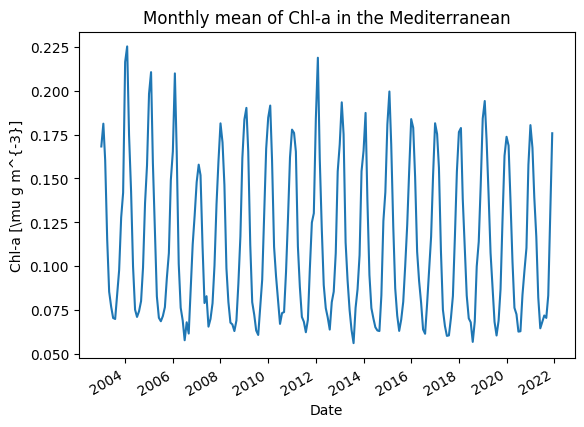

In [25]:
ax_=TM_Chla_m.plot(kind='line',
                    legend= False,
                    ylabel='Chl-a [\mu g m^{-3}]',
                    xlabel='Date',
                    title='Monthly mean of Chl-a in the Mediterranean')

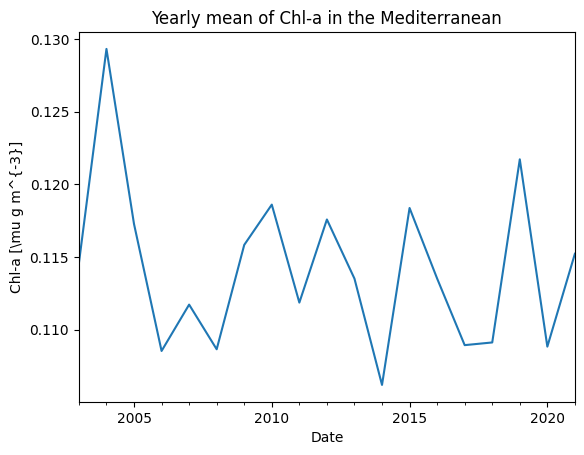

In [26]:
ax_=TM_Chla_y.plot(kind='line',
                    legend= False,
                    ylabel='Chl-a [\mu g m^{-3}]',
                    xlabel='Date',
                    title='Yearly mean of Chl-a in the Mediterranean')

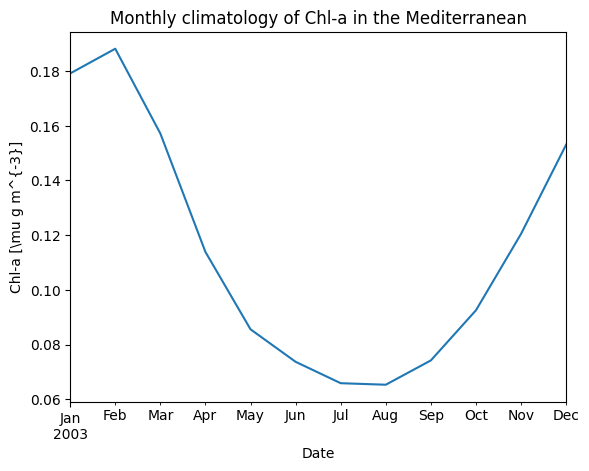

In [27]:
ax_=TM_Chla_mC.plot(kind='line',
                    legend= False,
                    ylabel='Chl-a [\mu g m^{-3}]',
                    xlabel='Date',
                    title='Monthly climatology of Chl-a in the Mediterranean')

# End of exercise assignment

Exercises to carry out with the skills you have obtained above. 

* **Select your region of interest and carry out spatial subset.**

* **Plot the time series of temperature together with Chla-, and compare, do they correspond? Carry out this for yearly and monthly climatology**